### Detroit Blight Ticket Compliance

For more contex on this code, please read the [Kaggle description](https://www.kaggle.com/c/detroit-blight-ticket-compliance/overview) of this issue. Do not forget to read the [README file](https://github.com/Chinnasf/Applied-Data-Science/blob/master/README.md).

---

**Date of Creation**: Jul 16, 2020<br>
**Author**: Karina Chiñas Fuentes<br>
**Email**: chinnasf@outlook.de

---


**OBJECTIVE**: create a function that trains a model to predict blight ticket compliance in Detroit using `Data/train.csv`. Create a  python `Series` with the data being the probability that each corresponding ticket from `Data/test.csv` will be paid. Set `ticket_id` to be the index.

For instance:

    ticket_id
       284932    0.631642
       285362    0.701358
       285361    0.105925
       285338    0.068609
                 ...
       376499    0.100557
       376500    0.019050
       369851    0.029639
       Name: compliance, dtype: dtype: float64

The model should have an Area Under the ROC Curve ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) greater than 0.75.



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

%matplotlib notebook

# Load train dataset
train = pd.read_csv("Data/train_bt.csv", encoding = 'ISO-8859-1',
                                 dtype={'zip_code': np.str,
                                        'non_us_str_code': np.str,
                                        'grafitti_status': np.str},
                                 low_memory=False)
# Load test dataset
test  = pd.read_csv("Data/test_bt.csv")
# -------------------------------------------------------------------------------------
# Adding latitude and longitude to the train and test datasets given the id: ----------
addresses = pd.read_csv("Data/addresses_bt.csv")
latlon    = pd.read_csv("Data/latlons_bt.csv")

latlon    = latlon[latlon.address.isin(addresses["address"])]
addresses["lat"] = addresses.address.map(dict(latlon[["address","lat"]].values))
addresses["lon"] = addresses.address.map(dict(latlon[["address","lon"]].values))
addresses.drop("address",axis=1,inplace=True)

train.set_index("ticket_id",inplace=True)
test.set_index("ticket_id",inplace=True)
addresses.set_index("ticket_id",inplace=True)

train = (pd.concat([train,addresses], axis=1, join='inner')).reset_index()
test  = (pd.concat([test,addresses],  axis=1, join='inner')).reset_index()
# -------------------------------------------------------------------------------------
# since those who were found not responsible are not being considered:
train.dropna(subset=["compliance"],inplace=True)

# SELECTING FEATURES ------------------------------------------------------------------
# ticket_id should not be used as a feature.
features = ["judgment_amount",  # "violation_code" would be a good one.
            "fine_amount",
            "admin_fee",
            "state_fee",
            "late_fee",
            "discount_amount",
            "lat","lon"]

train = train[["ticket_id"]+features+["compliance"]]
train.dropna(inplace=True)

# Splitting data
# X should contain all features
X_train = train.drop(["ticket_id","compliance"],axis=1)
X_test  = (test[features]).fillna(test[features].mean())
# y should contain all labels
y_train = train["compliance"]

<IPython.core.display.Javascript object>


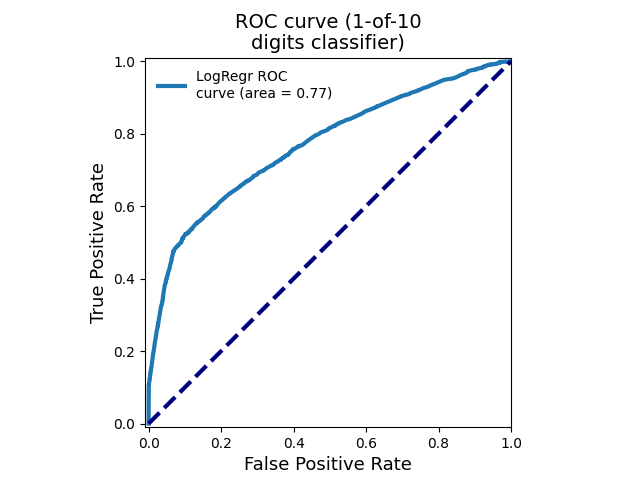

In [2]:
# --------------------------------------------------------------------------------------
# Model Creation and  Evaluation--------------------------------------------------------

# Feature Normalization
from sklearn.preprocessing import MinMaxScaler
mm_scaler  = MinMaxScaler()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train,y_train, random_state=0)

X_train_scaled_ = mm_scaler.fit_transform(X_train_)
X_test_scaled_  = mm_scaler.transform(X_test_)

model = GradientBoostingClassifier()

y_score = model.fit(X_train_scaled_, y_train_).decision_function(X_test_scaled_)
fpr,tpr, _ = roc_curve(y_test_, y_score)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC\ncurve (area = {:0.2f})'.format(auc(fpr, tpr)))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title("ROC curve (1-of-10\ndigits classifier)", fontsize=14)
plt.legend(loc=0, fontsize=10, frameon=False)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.gca().set_aspect('equal')
plt.show()

In [3]:
# Creating the Series with results
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled  = mm_scaler.transform(X_test)

y_predict_proba = model.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

not_paid = y_predict_proba[:,0] # The probability of the label being 1
paid = y_predict_proba[:,1] # The probability of the label being 1


test["compliance"] = y_predict_proba[:,1]
test = test[["ticket_id"]+features+["compliance"]].set_index("ticket_id")
test["compliance"]

ticket_id
284932    0.055158
285362    0.019651
285361    0.056104
285338    0.081775
285346    0.090511
            ...   
376496    0.022728
376497    0.022728
376499    0.059187
376500    0.059187
369851    0.267028
Name: compliance, Length: 61001, dtype: float64